## Importando Bibliotecas

In [35]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

## Definindo Hiperparâmetros

In [36]:
args = {
    'batch_size': 100,
    'num_workers': 16,
    'epoch_num': 300,
    'lr': 0.006,
    'weight_decay': 3e-05,
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

args

{'batch_size': 100,
 'num_workers': 16,
 'epoch_num': 300,
 'lr': 0.006,
 'weight_decay': 3e-05,
 'device': device(type='cpu')}

## Lendo arquivo com os dados

In [37]:
df = pd.read_csv('carros_sp_sem_outliers.csv')
df = pd.read_csv('ka.csv')
df

,modelo,marca,combustivel,cambio,direcao,cor,ano,quilometragem,potenciamotor,blindado,valor
0,4159,8,4,2,1,0,2017,76000,1.0,0,39990.0
1,4159,8,4,2,1,9,2018,99999,1.0,0,39990.0
2,4159,8,4,2,1,0,2015,36000,1.0,0,37490.0
3,4159,8,4,2,2,0,2017,64000,1.0,0,37500.0
4,4159,8,4,2,2,0,2017,87000,1.0,0,33000.0
...,...,...,...,...,...,...,...,...,...,...,...
532,4159,8,4,2,1,2,2019,30600,1.0,0,45900.0
533,4159,8,4,2,1,9,2018,63000,1.0,0,39999.0
534,4159,8,4,2,2,5,2019,28800,1.0,0,45000.0
535,4159,8,4,2,1,9,2018,81000,1.0,0,43500.0


In [38]:
#df.drop(['combustivel', 'blindado', 'cor', 'potenciamotor'], axis=1,  inplace=True)
#df

## Separando em conjunto de teste e de treino

In [39]:
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))

df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

df_train.to_csv('car_train.csv', index=False)
df_test.to_csv('car_test.csv', index=False)

print(df_train.shape, df_test.shape)

(429, 11) (108, 11)


## Classe Carro

In [40]:
class Car(Dataset):
    def __init__(self, csv_path, columns):
        self.dados = pd.read_csv(csv_path).to_numpy()        
        self.columns = columns

    def __getitem__(self, idx):        
        sample = self.dados[idx][:self.columns]
        label = self.dados[idx][-1:]

        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))

        return sample, label

    def __len__(self):
        return len(self.dados)


## Carregando dados de treino e de teste

In [41]:
train_set = Car('car_train.csv', df.shape[1]-1)
test_set = Car('car_test.csv', df.shape[1]-1)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)

test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

## Criando MLP

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(MLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, out_size),
            nn.ReLU(),
        )

    def forward(self, X):

        hidden = self.features(X)
        output = self.classifier(hidden)

        return output

In [43]:
input_size = train_set[0][0].shape[0]
hidden_size = int((train_set[0][0].shape[0] + 1) / 2)
out_size = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])

net

MLP(
  (features): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): ReLU()
  )
)

## Definindo loss e otimizador

In [44]:
criterion = nn.L1Loss().to(args['device'])
diferenca = nn.L1Loss().to(args['device'])

#optimizer = optim.Adam(net.parameters(), 
#                       lr=args['lr'], 
#                       weight_decay=args['weight_decay'])

optimizer = optim.Adam(net.parameters())

dif_train, dif_test = [], []

## Treino e Validação

In [45]:
def train(train_loader, net, epoch):
    # Training mode
    net.train()
    start = time.time()
    epoch_loss  = []    
    epoch_dif = []
    
    for batch in train_loader:
        dado, rotulo = batch
    
        # Cast do dado na GPU
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])

        optimizer.zero_grad()
        
        # Forward
        ypred = net(dado)
        loss = criterion(ypred, rotulo)
        
        dif = diferenca(ypred, rotulo)
        dif_train.append(dif.cpu().data)
        
        epoch_dif.append(dif.cpu().data)
        epoch_loss.append(loss.cpu().data)

        # Backpropagation
        loss.backward()
        optimizer.step()
   
    epoch_loss = np.asarray(epoch_loss)
    epoch_dif = np.asarray(epoch_dif)
  
    end = time.time()
    print('#################### Train ####################')
    print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_dif.mean(), end-start))

    return epoch_loss.mean()

In [46]:
def validate(test_loader, net, epoch):
    # Evaluation mode
    net.eval()
    start = time.time()
    epoch_loss  = []
    epoch_dif = []

    with torch.no_grad(): 
        for batch in test_loader:
            dado, rotulo = batch

            # Cast do dado na GPU
            dado = dado.to(args['device'])
            rotulo = rotulo.to(args['device'])
            
            optimizer.zero_grad()
            
            # Forward
            ypred = net(dado)
            loss = criterion(ypred, rotulo)
            
            dif = diferenca(ypred, rotulo)
            dif_test.append(dif.cpu().data)
            
            epoch_dif.append(dif.cpu().data)
            epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)
    epoch_dif = np.asarray(epoch_dif)

    end = time.time()
    print('********** Validate **********')
    print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_dif.mean(), end-start))

    return epoch_loss.mean()

## Treinamento

In [47]:
train_losses, test_losses = [], []
start = time.time()

for epoch in range(args['epoch_num']):
    # Train
    train_losses.append(train(train_loader, net, epoch))

    # Validate
    test_losses.append(validate(test_loader, net, epoch))

end = time.time()
print(end-start)

#################### Train ####################
Epoch 0, Loss: 39967.4453 +/- 39967.4453, Time: 0.23
********** Validate **********
Epoch 0, Loss: 41034.4336 +/- 41034.4336, Time: 0.21

#################### Train ####################
Epoch 1, Loss: 40541.1250 +/- 40541.1250, Time: 0.22
********** Validate **********
Epoch 1, Loss: 41021.0547 +/- 41021.0547, Time: 0.20

#################### Train ####################
Epoch 2, Loss: 40147.5625 +/- 40147.5625, Time: 0.23
********** Validate **********
Epoch 2, Loss: 41004.7578 +/- 41004.7578, Time: 0.21

#################### Train ####################
Epoch 3, Loss: 40177.7227 +/- 40177.7227, Time: 0.20
********** Validate **********
Epoch 3, Loss: 40981.4492 +/- 40981.4492, Time: 0.20

#################### Train ####################
Epoch 4, Loss: 40232.2539 +/- 40232.2539, Time: 0.20
********** Validate **********
Epoch 4, Loss: 40948.4922 +/- 40948.4922, Time: 0.18

#################### Train ####################
Epoch 5, Loss: 40256.4

#################### Train ####################
Epoch 44, Loss: 15375.1816 +/- 15375.1816, Time: 0.20
********** Validate **********
Epoch 44, Loss: 14959.7363 +/- 14959.7363, Time: 0.18

#################### Train ####################
Epoch 45, Loss: 14968.5059 +/- 14968.5059, Time: 0.22
********** Validate **********
Epoch 45, Loss: 15029.9434 +/- 15029.9434, Time: 0.19

#################### Train ####################
Epoch 46, Loss: 15454.7344 +/- 15454.7344, Time: 0.19
********** Validate **********
Epoch 46, Loss: 15043.0898 +/- 15043.0898, Time: 0.21

#################### Train ####################
Epoch 47, Loss: 15351.0215 +/- 15351.0215, Time: 0.21
********** Validate **********
Epoch 47, Loss: 15066.3750 +/- 15066.3750, Time: 0.19

#################### Train ####################
Epoch 48, Loss: 15016.2139 +/- 15016.2139, Time: 0.21
********** Validate **********
Epoch 48, Loss: 15010.1094 +/- 15010.1094, Time: 0.21

#################### Train ####################
Epoch 49, Lo

#################### Train ####################
Epoch 88, Loss: 13398.4404 +/- 13398.4404, Time: 0.22
********** Validate **********
Epoch 88, Loss: 13217.6406 +/- 13217.6406, Time: 0.19

#################### Train ####################
Epoch 89, Loss: 12885.3027 +/- 12885.3027, Time: 0.20
********** Validate **********
Epoch 89, Loss: 13156.8789 +/- 13156.8789, Time: 0.20

#################### Train ####################
Epoch 90, Loss: 13359.0391 +/- 13359.0391, Time: 0.22
********** Validate **********
Epoch 90, Loss: 13053.0684 +/- 13053.0684, Time: 0.18

#################### Train ####################
Epoch 91, Loss: 13203.2637 +/- 13203.2637, Time: 0.20
********** Validate **********
Epoch 91, Loss: 12980.2207 +/- 12980.2207, Time: 0.21

#################### Train ####################
Epoch 92, Loss: 12999.2393 +/- 12999.2393, Time: 0.19
********** Validate **********
Epoch 92, Loss: 12976.8262 +/- 12976.8262, Time: 0.21

#################### Train ####################
Epoch 93, Lo

********** Validate **********
Epoch 131, Loss: 6380.6738 +/- 6380.6738, Time: 0.22

#################### Train ####################
Epoch 132, Loss: 6093.0063 +/- 6093.0063, Time: 0.21
********** Validate **********
Epoch 132, Loss: 6055.7021 +/- 6055.7021, Time: 0.20

#################### Train ####################
Epoch 133, Loss: 5776.6655 +/- 5776.6655, Time: 0.19
********** Validate **********
Epoch 133, Loss: 5714.4141 +/- 5714.4141, Time: 0.21

#################### Train ####################
Epoch 134, Loss: 5641.1201 +/- 5641.1201, Time: 0.22
********** Validate **********
Epoch 134, Loss: 5280.8643 +/- 5280.8643, Time: 0.19

#################### Train ####################
Epoch 135, Loss: 5285.9282 +/- 5285.9282, Time: 0.22
********** Validate **********
Epoch 135, Loss: 4906.1240 +/- 4906.1240, Time: 0.20

#################### Train ####################
Epoch 136, Loss: 4701.9688 +/- 4701.9688, Time: 0.21
********** Validate **********
Epoch 136, Loss: 4673.3950 +/- 4673.395

#################### Train ####################
Epoch 176, Loss: 3102.7837 +/- 3102.7837, Time: 0.23
********** Validate **********
Epoch 176, Loss: 2875.8064 +/- 2875.8064, Time: 0.21

#################### Train ####################
Epoch 177, Loss: 2968.3467 +/- 2968.3467, Time: 0.22
********** Validate **********
Epoch 177, Loss: 2881.3721 +/- 2881.3721, Time: 0.22

#################### Train ####################
Epoch 178, Loss: 2902.0845 +/- 2902.0845, Time: 0.22
********** Validate **********
Epoch 178, Loss: 2874.1230 +/- 2874.1230, Time: 0.22

#################### Train ####################
Epoch 179, Loss: 3029.6086 +/- 3029.6086, Time: 0.22
********** Validate **********
Epoch 179, Loss: 2873.9116 +/- 2873.9116, Time: 0.22

#################### Train ####################
Epoch 180, Loss: 2896.4211 +/- 2896.4211, Time: 0.20
********** Validate **********
Epoch 180, Loss: 2876.7861 +/- 2876.7861, Time: 0.19

#################### Train ####################
Epoch 181, Loss: 2976.

********** Validate **********
Epoch 220, Loss: 2874.8162 +/- 2874.8162, Time: 0.22

#################### Train ####################
Epoch 221, Loss: 3032.2351 +/- 3032.2351, Time: 0.21
********** Validate **********
Epoch 221, Loss: 2875.1523 +/- 2875.1523, Time: 0.20

#################### Train ####################
Epoch 222, Loss: 2964.2749 +/- 2964.2749, Time: 0.20
********** Validate **********
Epoch 222, Loss: 2884.3416 +/- 2884.3416, Time: 0.19

#################### Train ####################
Epoch 223, Loss: 3002.0173 +/- 3002.0173, Time: 0.22
********** Validate **********
Epoch 223, Loss: 2880.3398 +/- 2880.3398, Time: 0.18

#################### Train ####################
Epoch 224, Loss: 2942.0320 +/- 2942.0320, Time: 0.20
********** Validate **********
Epoch 224, Loss: 2873.8394 +/- 2873.8394, Time: 0.20

#################### Train ####################
Epoch 225, Loss: 3178.6445 +/- 3178.6445, Time: 0.21
********** Validate **********
Epoch 225, Loss: 2875.2998 +/- 2875.299

#################### Train ####################
Epoch 265, Loss: 3020.3423 +/- 3020.3423, Time: 0.21
********** Validate **********
Epoch 265, Loss: 2889.2681 +/- 2889.2681, Time: 0.21

#################### Train ####################
Epoch 266, Loss: 3086.7183 +/- 3086.7183, Time: 0.22
********** Validate **********
Epoch 266, Loss: 2877.1133 +/- 2877.1133, Time: 0.20

#################### Train ####################
Epoch 267, Loss: 2918.4285 +/- 2918.4285, Time: 0.21
********** Validate **********
Epoch 267, Loss: 2880.9570 +/- 2880.9570, Time: 0.21

#################### Train ####################
Epoch 268, Loss: 2930.5063 +/- 2930.5063, Time: 0.22
********** Validate **********
Epoch 268, Loss: 2877.6782 +/- 2877.6782, Time: 0.21

#################### Train ####################
Epoch 269, Loss: 3027.8481 +/- 3027.8481, Time: 0.21
********** Validate **********
Epoch 269, Loss: 2874.3049 +/- 2874.3049, Time: 0.19

#################### Train ####################
Epoch 270, Loss: 3035.

## Grafico de Convergência

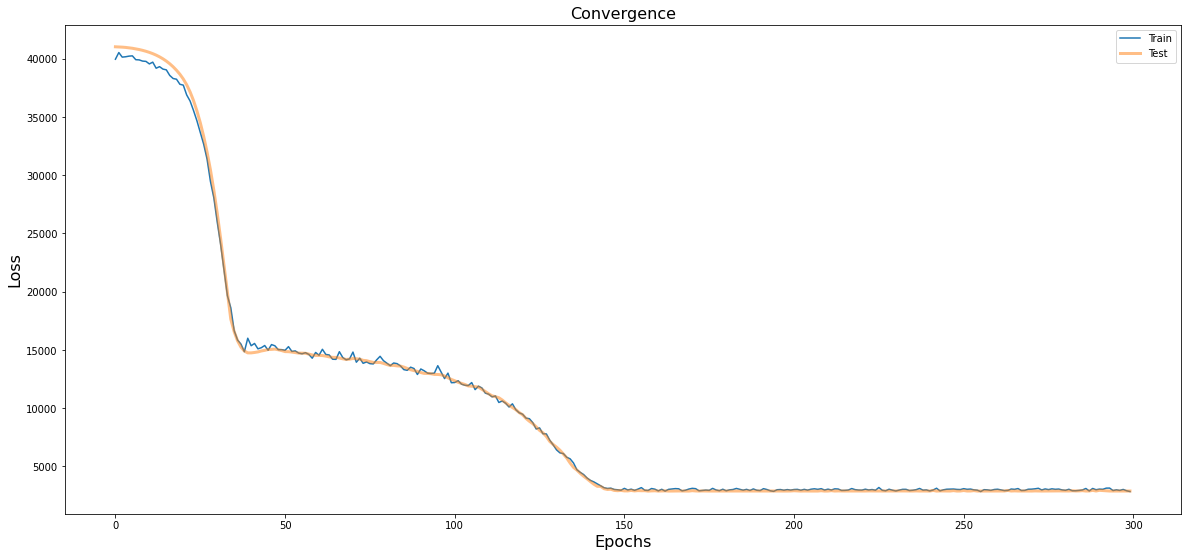

In [48]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

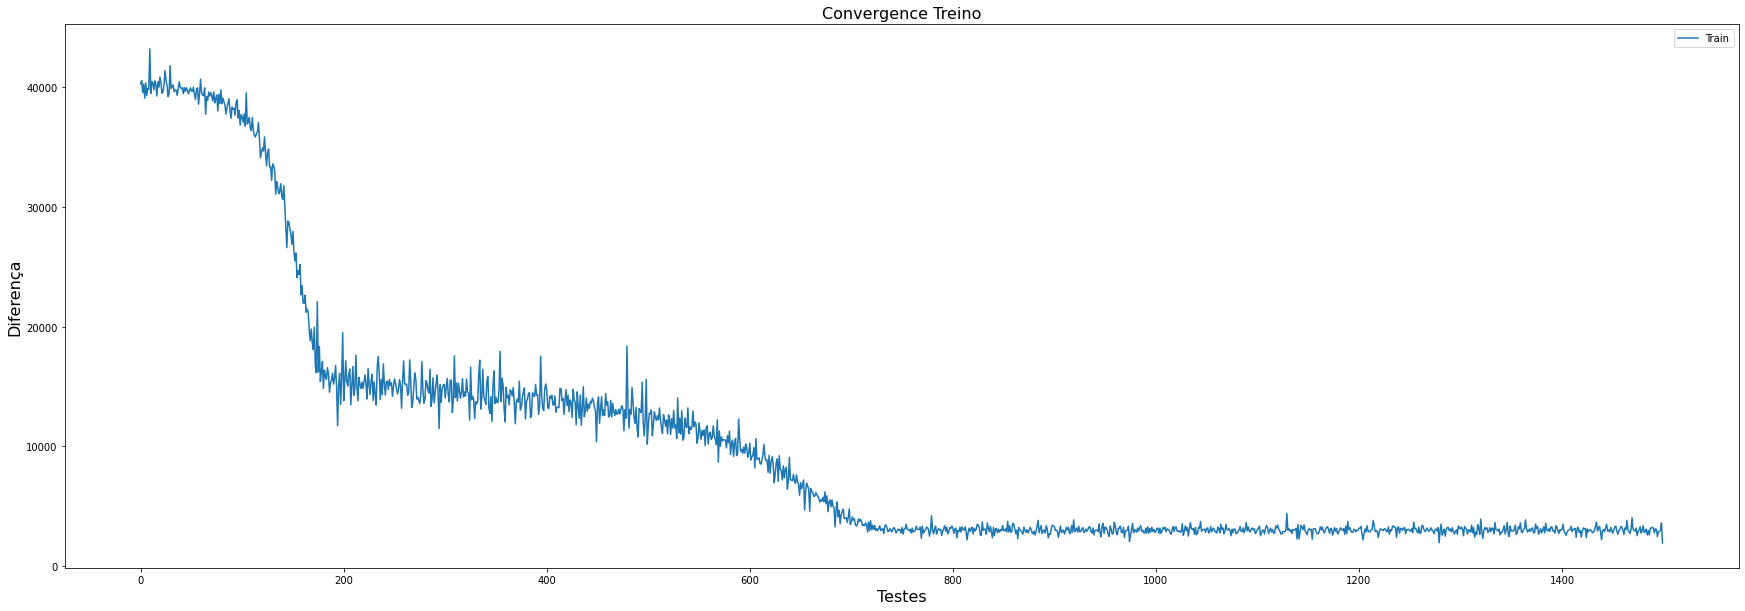

In [70]:
plt.figure(figsize=(30, 10))
plt.plot(dif_train, label='Train')
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Treino', fontsize=16)
plt.legend()
plt.show()

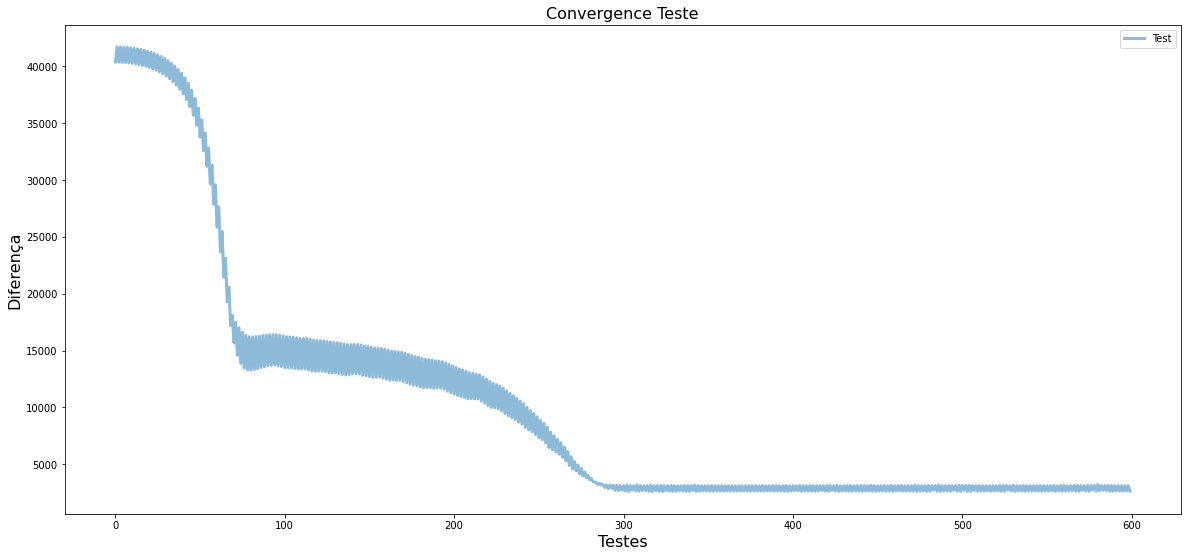

In [50]:
plt.figure(figsize=(20, 9))
plt.plot(dif_test, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Teste', fontsize=16)
plt.legend()
plt.show()

## Melhores Loss

In [51]:
train_losses = np.asarray(train_losses)
print(min(train_losses), max(train_losses), train_losses.mean())

2829.6199 40541.125 10023.288


In [52]:
test_losses = np.asarray(test_losses)
print(min(test_losses), max(test_losses), test_losses.mean())

2868.2302 41034.434 10018.181


In [53]:
dif_train = np.asarray(dif_train)
print(min(dif_train), max(dif_train), dif_train.mean())

1900.6067 43222.617 10023.289


In [54]:
dif_test = np.asarray(dif_test)
print(min(dif_test), max(dif_test), dif_test.mean())

2598.5093 41700.754 10018.179


In [55]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    if var_name == "param_groups":
        print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]


In [56]:
# [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]

In [57]:
torch.save(net, 'modelo_classificao-3')

In [58]:
testeModelo = torch.load('modelo_classificao-3')
testeModelo.eval()

MLP(
  (features): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): ReLU()
  )
)

In [59]:
#lista = [1425,45,4,2,2,0,2019, 61000, 1.6,0]
#tensor = torch.FloatTensor(lista)
#valor = testeModelo.forward(tensor).item()
#valor

In [60]:
vw = pd.read_csv('ka.csv')
#vw.drop(['combustivel', 'blindado', 'cor', 'potenciamotor'], axis=1, inplace=True)
vw.head()

,modelo,marca,combustivel,cambio,direcao,cor,ano,quilometragem,potenciamotor,blindado,valor
0,4159,8,4,2,1,0,2017,76000,1.0,0,39990.0
1,4159,8,4,2,1,9,2018,99999,1.0,0,39990.0
2,4159,8,4,2,1,0,2015,36000,1.0,0,37490.0
3,4159,8,4,2,2,0,2017,64000,1.0,0,37500.0
4,4159,8,4,2,2,0,2017,87000,1.0,0,33000.0


In [61]:
dif = []
real = []
previsto = []
for i in range(vw.shape[0]):
    tensor = torch.FloatTensor(np.asarray(vw.iloc[i, :-1]))    
    valor = testeModelo.forward(tensor).item()
    dif.append(float(round(valor-np.asarray(vw.iloc[i,-1]), 2)))
    print(f"{np.asarray(vw.iloc[i,-1])} -> {round(valor, 2)} => {round(valor-np.asarray(vw.iloc[i,-1]), 2)}")    
    real.append(vw.iloc[i,-1])
    previsto.append(valor)

39990.0 -> 39086.62 => -903.38
39990.0 -> 37171.71 => -2818.29
37490.0 -> 42354.57 => 4864.57
37500.0 -> 40075.69 => 2575.69
33000.0 -> 38189.72 => 5189.72
39900.0 -> 37024.58 => -2875.42
38000.0 -> 38565.61 => 565.61
35900.0 -> 38798.7 => 2898.7
39000.0 -> 40626.0 => 1626.0
41000.0 -> 43844.46 => 2844.46
41900.0 -> 40814.6 => -1085.4
34990.0 -> 37799.18 => 2809.18
33500.0 -> 42847.25 => 9347.25
40900.0 -> 41031.89 => 131.89
38000.0 -> 39615.16 => 1615.16
46000.0 -> 41834.27 => -4165.73
44600.0 -> 43116.56 => -1483.44
38900.0 -> 42245.11 => 3345.11
45900.0 -> 42978.68 => -2921.32
38000.0 -> 37252.72 => -747.28
36990.0 -> 39993.04 => 3003.04
46900.0 -> 43367.64 => -3532.36
36850.0 -> 38500.63 => 1650.63
37900.0 -> 38776.05 => 876.05
43900.0 -> 39030.81 => -4869.19
37990.0 -> 42242.64 => 4252.64
39900.0 -> 38073.62 => -1826.38
30500.0 -> 39735.7 => 9235.7
39900.0 -> 41469.68 => 1569.68
34790.0 -> 38219.61 => 3429.61
42990.0 -> 42392.68 => -597.32
29900.0 -> 36701.74 => 6801.74
34500.0 ->

34000.0 -> 45290.86 => 11290.86
42890.0 -> 37543.74 => -5346.26
36900.0 -> 40182.23 => 3282.23
45900.0 -> 42049.66 => -3850.34
43900.0 -> 44018.55 => 118.55
41790.0 -> 38989.47 => -2800.53
46290.0 -> 41561.32 => -4728.68
38900.0 -> 40391.69 => 1491.69
39000.0 -> 40205.59 => 1205.59
46500.0 -> 41019.53 => -5480.47
38000.0 -> 39824.61 => 1824.61
40990.0 -> 42631.86 => 1641.86
39000.0 -> 40446.23 => 1446.23
44700.0 -> 45358.68 => 658.68
38900.0 -> 38944.15 => 44.15
38000.0 -> 41370.59 => 3370.59
42000.0 -> 42588.64 => 588.64
30900.0 -> 43551.43 => 12651.43
39000.0 -> 40527.6 => 1527.6
38990.0 -> 39867.8 => 877.8
41200.0 -> 40892.99 => -307.01
42900.0 -> 41142.59 => -1757.41
41200.0 -> 38729.61 => -2470.39
44610.0 -> 41075.52 => -3534.48
39800.0 -> 40400.8 => 600.8
49800.0 -> 39636.68 => -10163.32
36500.0 -> 40438.68 => 3938.68
34320.0 -> 41488.27 => 7168.27
34999.0 -> 35665.77 => 666.77
37000.0 -> 38296.25 => 1296.25
39900.0 -> 42459.66 => 2559.66
41550.0 -> 38150.27 => -3399.73
51900.0 -

In [62]:
dif = np.asarray(dif)

In [63]:
dif

array([-9.033800e+02, -2.818290e+03,  4.864570e+03,  2.575690e+03,
        5.189720e+03, -2.875420e+03,  5.656100e+02,  2.898700e+03,
        1.626000e+03,  2.844460e+03, -1.085400e+03,  2.809180e+03,
        9.347250e+03,  1.318900e+02,  1.615160e+03, -4.165730e+03,
       -1.483440e+03,  3.345110e+03, -2.921320e+03, -7.472800e+02,
        3.003040e+03, -3.532360e+03,  1.650630e+03,  8.760500e+02,
       -4.869190e+03,  4.252640e+03, -1.826380e+03,  9.235700e+03,
        1.569680e+03,  3.429610e+03, -5.973200e+02,  6.801740e+03,
        5.738130e+03, -2.785160e+03, -7.212430e+03,  3.320020e+03,
        5.807540e+03,  6.528540e+03, -7.409500e+02,  1.160710e+03,
       -4.027000e+01, -3.808570e+03,  2.601910e+03,  3.145570e+03,
        3.555600e+02, -4.586960e+03,  3.076760e+03, -1.061350e+03,
       -5.063200e+02, -1.726440e+03,  4.508220e+03,  1.587230e+03,
       -1.304870e+03, -3.800000e+00, -6.783900e+02, -5.423410e+03,
        4.403420e+03,  4.774230e+03,  2.390590e+03, -7.000100e

In [64]:
print(min(dif), max(dif), dif.mean())

-10163.32 13721.76 270.5529981378026


In [65]:
print(min(dif[dif > 0]), max(dif[dif > 0]), dif[dif > 0].mean())

12.61 13721.76 3223.210625


In [66]:
dif[dif > 0].std()

2806.137807965096

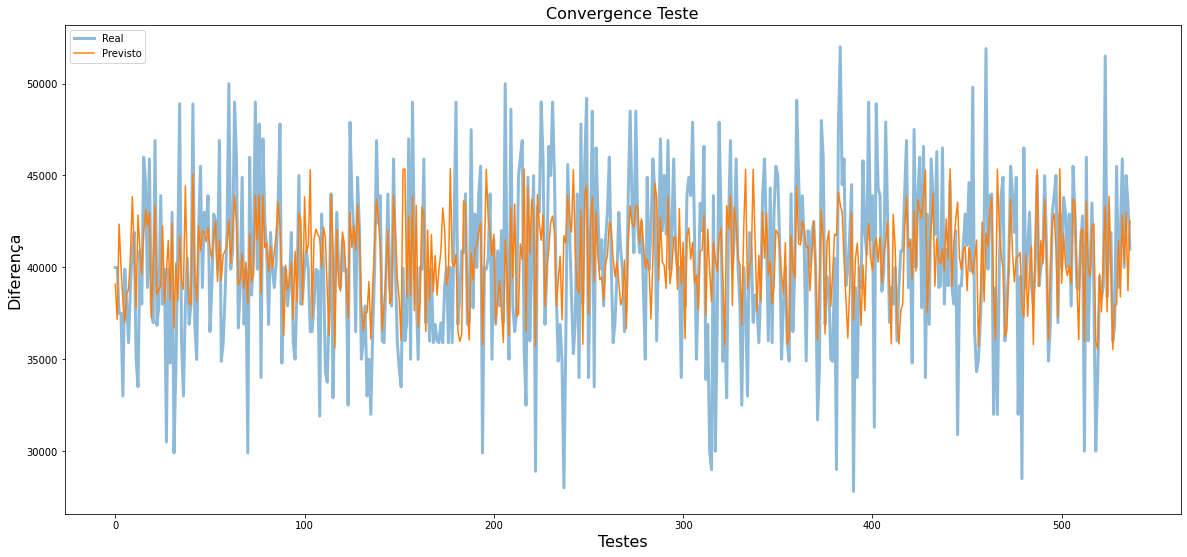

In [67]:
plt.figure(figsize=(20, 9))
plt.plot(real, label='Real', linewidth=3, alpha=0.5)
plt.plot(previsto, label='Previsto')
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Teste', fontsize=16)
plt.legend()
plt.show()

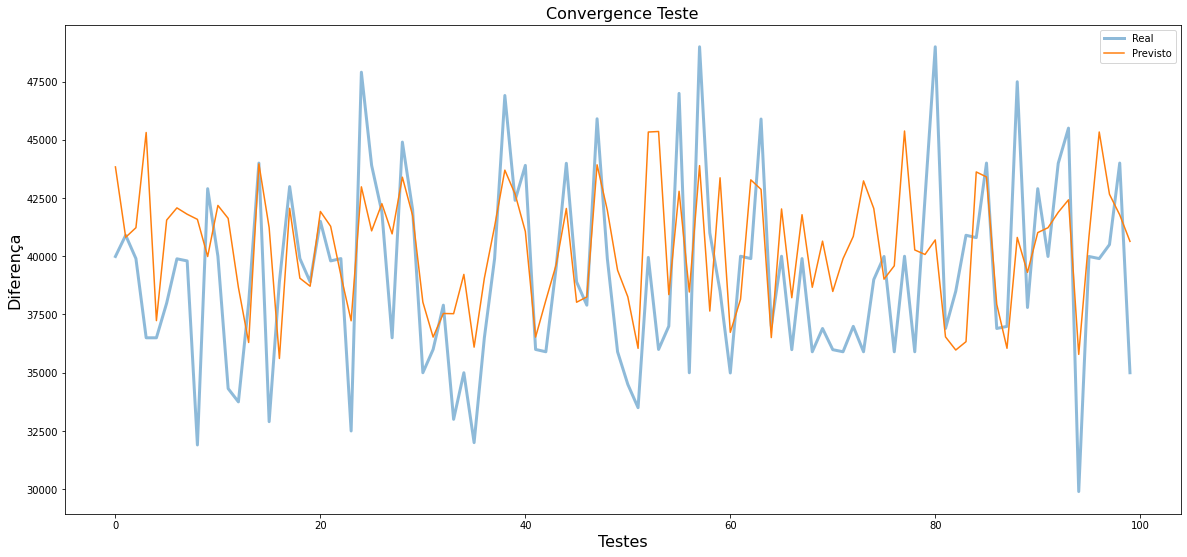

In [68]:
plt.figure(figsize=(20, 9))
plt.plot(real[100:200], label='Real', linewidth=3, alpha=0.5)
plt.plot(previsto[100:200], label='Previsto')
plt.xlabel('Testes', fontsize=16)
plt.ylabel('Diferença', fontsize=16)
plt.title('Convergence Teste', fontsize=16)
plt.legend()
plt.show()